In [1]:
import tensorflow as tf

import os
import sys
import numpy as np
from scipy.io import savemat

# Add the Torch_code directory to the Python path
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath('helper'))
# import utils
# import loader
import utils_UDA_CNN15

2025-05-31 11:09:13.463718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748704153.477909  280537 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748704153.482262  280537 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748704153.493351  280537 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748704153.493364  280537 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748704153.493365  280537 computation_placer.cc:177] computation placer alr

In [2]:
notebook_dir = os.getcwd()
print(notebook_dir)
print(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
import Est_btween_CSIRS.helper.utils as utils_CNN
import Est_btween_CSIRS.helper.loader as loader
import Est_btween_CSIRS.helper.plotfig as plotfig

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Domain_Adaptation/Domain_Adversarial
/home/thien/Code/H_predict_UDA/H_predict_Sionna


In [3]:
data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'CDL_Channel', 'generatedChannel', 'ver3_'))
print(data_file_path)
source_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'CDL_Channel', 
                                                    'generatedChannel', 'ver3_', '5dB', 'mapBaseData.mat'))
target_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'Sionna', 
                                                    'generatedChannel', 'ver3_'))

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Generate_Data/CDL_Channel/generatedChannel/ver3_


In [4]:
learning_rate = 0.0001
norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
    
# snr_start = -25
# snr_step = 5
# snr_end = 25
# SNR = np.arange(snr_start, snr_end+1, snr_step)

# SNR = np.array([0])

# if len(SNR) >1:
#     SNR_txt = f'{snr_start}:{snr_step}:{snr_end}'
# else:
#     SNR_txt = f'{SNR[0]}'
    
# ============ CNN settings ==============
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
CNN_activation = 'Tanh'
CNN_DropOut = 0.2
if CNN_DropOut != 0:
    dropOut_txt = f'Add p={CNN_DropOut} DropOut'
    
# ============ Adversarial for Domain Discriminator settings ==============
extract_layer = 3  # extract features after convelution layer 3 
# extract_layer = 5
lambda_domain=0.1
text_lambda = f'lambda_domain = {lambda_domain}'
    
    
# create readme.txt file
content = f"""Generated by file 'Domain_Adversarial/UDA_CNN_v1.ipynb'.
28 GHz fc,
Source dataset got from {source_data_file_path},
Target dataset got from {target_data_file_path},
Learning rate {learning_rate},
{norm_txt} scaler for each sample
Using {CNN_activation} as activation function of CNN
{dropOut_txt}
========= For Domain Discriminator ==========
Extract features after layer {extract_layer} of CNN
{text_lambda}
"""

In [5]:
# Paths to save
idx_save_path = loader.find_incremental_filename(notebook_dir + '/model/CNN','ver', '_', '')

model_path = notebook_dir + '/model/CNN/ver' + str(idx_save_path) + '_'
# figure_path = notebook_dir + '/model/CNN/ver' + str(idx_save_path) + '_/figure'
model_readme = model_path + '/readme.txt'
# figure_readme = figure_path + '/readme.txt'

if not os.path.exists(os.path.dirname(model_readme)):
    os.makedirs(os.path.dirname(model_readme))
# if not os.path.exists(os.path.dirname(figure_readme)):
#     os.makedirs(os.path.dirname(figure_readme))

# Open the file in write mode ('w'). If the file does not exist, it will be created.
with open(model_readme, 'w') as file:
    # Write the content to the file
    file.write(content)

# with open(figure_readme, 'w') as file:
#     # Write the content to the file
#     file.write(content)

print(f"File '{model_readme}'  created and content written.")


File '/home/thien/Code/H_predict_UDA/H_predict_Sionna/Domain_Adaptation/Domain_Adversarial/model/CNN/ver10_/readme.txt'  created and content written.


In [6]:
import h5py

batch_size=16

# ============ Source data ==============
source_file = h5py.File(source_data_file_path, 'r')
H_true_source = source_file['H_true']
N_samp_source = H_true_source.shape[0]
print('N_samp_source = ', N_samp_source)

# ============ Target data ==============
target_file = h5py.File(target_data_file_path+'/sionnaTrue.mat', 'r')
H_true_target = target_file['H_true']
N_samp_target = H_true_target.shape[0]
print('N_samp_target = ', N_samp_target)

N_samp_source =  2048
N_samp_target =  2048


In [7]:
indices_source = np.arange(N_samp_source)
np.random.shuffle(indices_source)
indices_target = np.arange(N_samp_target)
np.random.shuffle(indices_target)
#
train_size = int(np.floor(N_samp_source * 0.9) // batch_size * batch_size)
val_size = N_samp_source - train_size
print('train_size = ', train_size)
print('val_size = ', val_size)

# Repeat the indices to match the maximum number of samples
N_samp = max(N_samp_source, N_samp_target) 
indices_source = np.resize(indices_source, N_samp)
indices_target = np.resize(indices_target, N_samp)

# =======================================================
## Divide the indices into training and validation sets
indices_train_source = indices_source[:train_size]
indices_val_source   = indices_source[train_size:train_size + val_size]

indices_train_target = indices_target[:train_size]
indices_val_target   = indices_target[train_size:train_size + val_size]

# to test code
# indices_train_source = indices_source[:32]
# indices_val_source = indices_source[2032:]
# indices_train_target = indices_target[:32]
# indices_val_target = indices_target[2032:]

train_size =  1840
val_size =  208


In [8]:
# =========== Source dataset ==============
loader_H_true_train_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_source)
loader_H_1_6_11_train_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_1_6_11', batch_size=batch_size, shuffled_indices=indices_train_source)
    # channel at symbol 2 of slots 1,6,11 (channel corresponding to CSI-RS 1, 2, 3)
loader_H_true_val_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_source)
loader_H_1_6_11_val_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_1_6_11', batch_size=batch_size, shuffled_indices=indices_val_source)

# =========== Target dataset ==============
loader_H_true_train_target = utils_CNN.H5BatchLoader(target_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_target)
    # actually at target domain, we don't have true channels, just use this for evaluating the model
loader_H_1_6_11_train_target = utils_CNN.H5BatchLoader(target_file, 'H_linear_1_6', batch_size=batch_size, shuffled_indices=indices_train_target)
    # channel at symbol 2 of slots 1,6 (channel corresponding to CSI-RS 1, 2)
loader_H_true_val_target = utils_CNN.H5BatchLoader(target_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_target)
loader_H_1_6_11_val_target = utils_CNN.H5BatchLoader(target_file, 'H_linear_1_6', batch_size=batch_size, shuffled_indices=indices_val_target)

print('size loader_H_true_train = ', loader_H_true_train_target.total_batches)
print('size loader_H_true_val = ', loader_H_true_val_target.total_batches)

size loader_H_true_train =  115
size loader_H_true_val =  13


In [9]:
loss_fn_ce = tf.keras.losses.MeanSquaredError()  # Channel estimation loss
loss_fn_domain = tf.keras.losses.BinaryCrossentropy()  # Domain classification loss

In [10]:
from tensorflow.keras import optimizers, losses

n_epochs= 70
epoch_min = 30
epoch_step = 10
# n_epochs= 2
# epoch_min = 0
# epoch_step = 1

train_mode = ['in_15_symbs']
for sub_folder in train_mode:
    print(f"Processing: {sub_folder}")
    
    if not os.path.exists(os.path.dirname(model_path + '/' + sub_folder +'/')):
        os.makedirs(os.path.dirname(model_path + '/' + sub_folder + '/'))

    train_loss          = [] # (epoch,1)
    train_est_loss      = [] 
    train_domain_loss   = []
    train_est_loss_target = []
    #    
    val_loss, val_domain_loss_source, val_domain_loss_target, val_domain_loss,\
    val_est_loss_source, val_est_loss_target, val_est_loss,\
    source_acc, target_acc, acc,\
    nmse_val_source, nmse_val_target, nmse_val = [[] for _ in range(13)]
    #
    H_to_save = {}          # list to save to .mat file for H
    perform_to_save = {}    # list to save to .mat file for nmse, losses,...
    
    model = utils_UDA_CNN15.UDA_CNN(extractLayer=extract_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    flag = 1 # flag to plot and save H_true

    for epoch in range(n_epochs):
        # ===================== Training =====================
        loader_H_true_train_source.reset()
        loader_H_1_6_11_train_source.reset()
        loader_H_true_train_target.reset()
        loader_H_1_6_11_train_target.reset()
                
        loader_H = [loader_H_1_6_11_train_source, loader_H_true_train_source, loader_H_1_6_11_train_target, loader_H_true_train_target]
        loss_fn = [loss_fn_ce, loss_fn_domain, optimizer]
        #
        train_epoc_loss_est, train_epoc_loss_domain, train_epoc_loss, train_epoc_loss_est_target = utils_UDA_CNN15.train_step(model, 
                                                        loader_H, loss_fn, lower_range, lambda_domain=lambda_domain)
                # train_epoc_loss        = total train loss = loss_est + lambda_domain * domain_loss
                # train_epoc_loss_est    = loss in estimation network in source domain (labels available)
                # train_epoc_loss_domain = loss in domain discrimination network
                # train_epoc_loss_est_target - just to monitor - the machine can not calculate because no label available in source domain
                # All are already calculated in average over training dataset (source/target - respectively)
        # Average loss for the epoch
        train_loss.append(train_epoc_loss)
        print(f"epoch {epoch+1}/{n_epochs} Average Training Loss: {train_epoc_loss:.6f}")
        #
        train_est_loss.append(train_epoc_loss_est)
        print(f"epoch {epoch+1}/{n_epochs} Average Estimation Loss (in Source domain): {train_epoc_loss_est:.6f}")
        #
        train_domain_loss.append(train_epoc_loss_domain)
        print(f"epoch {epoch+1}/{n_epochs} Average Domain Discrimination Loss: {train_epoc_loss_domain:.6f}")
        #
        train_est_loss_target.append(train_epoc_loss_est_target)
        print(f"epoch {epoch+1}/{n_epochs} For observation only - Average Estimation Loss in Target domain: {train_epoc_loss_est_target:.6f}")
        
        
        # ===================== Evaluation =====================
        loader_H_true_val_source.reset()
        loader_H_1_6_11_val_source.reset()
        loader_H_true_val_target.reset()
        loader_H_1_6_11_val_target.reset()
        loader_H_eval = [loader_H_1_6_11_val_source, loader_H_true_val_source, loader_H_1_6_11_val_target, loader_H_true_val_target]

        loss_fn = loss_fn_ce, loss_fn_domain
        
        eval_func = utils_UDA_CNN15.val_step
        if (epoch+1>epoch_min and epoch%epoch_step==0) or epoch==n_epochs-1:
            H_sample, epoc_val_return = utils_UDA_CNN15.val_step(model, loader_H_eval, loss_fn, lower_range, epoch=epoch, lambda_domain=lambda_domain)
            print('Unpack H_sample and save for visualization')
            (
                H_true_sample,  H_input_sample, H_est_sample, H_input_condition, 
                nmse_input_source, nmse_est_source, domain_sample_return_source,
                H_true_sample_target, H_input_sample_target, H_est_sample_target, H_input_condition_target,
                nmse_input_target, nmse_est_target, domain_sample_return_target
            ) = H_sample
            
            # plot real parts
            # source domain
            if flag == 1:
                plotfig.figChan(H_true_sample[0,:,:,0], title='True channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_true_source')
                plotfig.figChan(H_input_sample[0,:,:,0], nmse=nmse_input_source[0], title='Raw-estimated Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_source')
                # if sub_folder == 'in_15_symbs' or sub_folder == 'FiLM':
                plotfig.figChan(H_input_condition[0,:,0,0], title='Condition Channel', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_condition_source')
            plotfig.figChan(H_est_sample[0,:,:,0], nmse=nmse_est_source[0], title='CNN-refined Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_CNN_source')
            # target domain
            if flag == 1:
                plotfig.figChan(H_true_sample_target[0,:,:,0], title='True channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_true_target')
                plotfig.figChan(H_input_sample_target[0,:,:,0], nmse=nmse_input_target[0], title='Raw-estimated Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_target')
                # if sub_folder == 'in_15_symbs' or sub_folder == 'FiLM':
                plotfig.figChan(H_input_condition_target[0,:,0,0], title='Condition Channel', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_condition_target')
                flag = 0
            plotfig.figChan(H_est_sample[0,:,:,0], nmse=nmse_est_target[0], title='CNN-refined Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_CNN_target')
            
            H_to_save[f'{epoch+1}_H_true_source'] = H_true_sample
            H_to_save[f'{epoch+1}_H_input_source'] = H_input_sample
            H_to_save[f'{epoch+1}_H_est_source'] = H_est_sample
            H_to_save[f'{epoch+1}_H_input_condition_source'] = H_input_condition
                # don't save nmse_input_source, nmse_est_source because can compute them later
            H_to_save[f'{epoch+1}_domain_sample_return_source'] = domain_sample_return_source
            #
            H_to_save[f'{epoch+1}_H_true_target'] = H_true_sample_target
            H_to_save[f'{epoch+1}_H_input_target'] = H_input_sample_target
            H_to_save[f'{epoch+1}_H_est_target'] = H_est_sample_target
            H_to_save[f'{epoch+1}_H_input_condition_target'] = H_input_condition_target
            H_to_save[f'{epoch+1}_domain_sample_return_target'] = domain_sample_return_target
            
        else:
            _, epoc_val_return = utils_UDA_CNN15.val_step(model, loader_H_eval, loss_fn, lower_range, lambda_domain=lambda_domain)
        
        (
            avg_epoc_total_loss, 
            avg_epoc_val_domain_loss_source, avg_epoc_val_domain_loss_target, avg_epoc_val_domain_loss,
            avg_epoc_val_est_loss_source, avg_epoc_val_est_loss_target, avg_epoc_val_est_loss,
            avg_epoc_source_acc, avg_epoc_target_acc, avg_epoc_acc,
            avg_epoc_nmse_val_source, avg_epoc_nmse_val_target, avg_epoc_nmse_val
        ) = epoc_val_return
        # Average loss for the epoch
        val_est_loss.append(avg_epoc_val_est_loss)
        print(f"epoch {epoch+1}/{n_epochs} (Val) Average Validating Loss: {avg_epoc_val_est_loss:.6f}")
        #
        val_est_loss_source.append(avg_epoc_val_est_loss_source)
        print(f"epoch {epoch+1}/{n_epochs} (Val) Average Estimation Loss (in Source domain): {avg_epoc_val_est_loss_source:.6f}")
        #
        val_loss.append(avg_epoc_total_loss)
        print(f"epoch {epoch+1}/{n_epochs} (Val) Average Domain Discrimination Loss: {avg_epoc_total_loss:.6f}")
        #
        val_est_loss_target.append(avg_epoc_val_est_loss_target)
        print(f"epoch {epoch+1}/{n_epochs} (Val) For observation only - Average Estimation Loss in Target domain: {avg_epoc_val_est_loss_target:.6f}")
        #
        val_domain_loss_source.append(avg_epoc_val_domain_loss_source)
        val_domain_loss_target.append(avg_epoc_val_domain_loss_target)
        val_domain_loss.append(avg_epoc_val_domain_loss)
        source_acc.append(avg_epoc_source_acc)
        target_acc.append(avg_epoc_target_acc)
        acc.append(avg_epoc_acc)
        nmse_val_source.append(avg_epoc_nmse_val_source)
        nmse_val_target.append(avg_epoc_nmse_val_target)
        nmse_val.append(avg_epoc_nmse_val)
        
        
        if (epoch+1>epoch_min and (epoch+1)%epoch_step==0) or epoch==n_epochs-1:
            # Save model
            os.makedirs(f"{model_path}/{sub_folder}/model/", exist_ok=True)
            model.save(f"{model_path}/{sub_folder}/model/epoch_{epoch+1}.keras")
            print(f"Model saved at epoch {epoch+1} to {model_path}/{sub_folder}/epoch_{epoch+1}")    
            
            # === save and overwrite at checkpoints
            # train
            perform_to_save['train_loss'] = train_loss
            perform_to_save['train_est_loss'] = train_est_loss
            perform_to_save['train_domain_loss'] = train_domain_loss
            perform_to_save['train_est_loss_target'] = train_est_loss_target
            # val
            perform_to_save['val_est_loss'] = val_est_loss
            perform_to_save['val_est_loss_source'] = val_est_loss_source
            perform_to_save['val_loss'] = val_loss
            perform_to_save['val_est_loss_target'] = val_est_loss_target
            perform_to_save['val_domain_loss_source'] = val_domain_loss_source
            perform_to_save['val_domain_loss_target'] = val_domain_loss_target
            perform_to_save['val_domain_loss'] = val_domain_loss
            perform_to_save['source_acc'] = source_acc
            perform_to_save['target_acc'] = target_acc
            perform_to_save['acc'] = acc
            perform_to_save['nmse_val_source'] = nmse_val_source
            perform_to_save['nmse_val_target'] = nmse_val_target
            perform_to_save['nmse_val'] = nmse_val
            # save
            os.makedirs(f"{model_path}/{sub_folder}/performance/", exist_ok=True)
            savemat(model_path + '/' + sub_folder + '/performance/performance.mat', perform_to_save)
            
            # Plot figures === save and overwrite at checkpoints
            plotfig.figLoss(line_list=[(nmse_val_source, 'Source Domain'), (nmse_val_target, 'Target Domain')], xlabel='Epoch', ylabel='NMSE',
                        title='NMSE in Validation', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='NMSE_val')
            plotfig.figLoss(line_list=[(source_acc, 'Source Domain'), (target_acc, 'Target Domain')], xlabel='Epoch', ylabel='Discrimination Accuracy',
                        title='Domain Discrimination Accuracy in Validation', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Domain_acc')
            #
            plotfig.figLoss(line_list=[(train_loss, 'Training'), (val_loss, 'Validating')], xlabel='Epoch', ylabel='Total Loss',
                        title='Training and Validating Total Loss', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Loss_total')
            plotfig.figLoss(line_list=[(train_est_loss, 'Training-Source'), (train_est_loss_target, 'Training-Target'), 
                                    (val_est_loss_source, 'Validating-Source'), (val_est_loss_target, 'Validating-Target')], xlabel='Epoch', ylabel='Estimation Loss',
                        title='Training and Validating Estimation Loss', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Loss_est')
            plotfig.figLoss(line_list=[(train_domain_loss, 'Training'), (val_domain_loss, 'Validating')], xlabel='Epoch', ylabel='Domain Discrimination Loss',
                        title='Training and Validating Domain Discrimination Loss', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Loss_domain')
            
    # end of epoch loop
    # =====================            
    # Save performances
    # Save H matrix
    savemat(model_path + '/' + sub_folder + '/H_visualize/H_trix.mat', H_to_save)
    
    

Processing: in_15_symbs


I0000 00:00:1748704157.802797  280537 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
I0000 00:00:1748704157.803413  280537 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9539 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
I0000 00:00:1748704157.803898  280537 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9264 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


batch_idx: 1/115


/home/thien/miniconda3/envs/TF_py311/lib/python3.11/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'domain_discriminator', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1748704161.504058  280537 cuda_dnn.cc:529] Loaded cuDNN version 90300


batch_idx: 21/115
batch_idx: 41/115
batch_idx: 61/115
batch_idx: 81/115
batch_idx: 101/115
batch_idx: 115/115
epoch 1/70 Average Training Loss: 0.177264
epoch 1/70 Average Estimation Loss (in Source domain): 0.199271
epoch 1/70 Average Domain Discrimination Loss: 0.776281
epoch 1/70 For observation only - Average Estimation Loss in Target domain: 0.209272
epoch 1/70 (Val) Average Validating Loss: 0.216388
epoch 1/70 (Val) Average Estimation Loss (in Source domain): 0.212461
epoch 1/70 (Val) Average Domain Discrimination Loss: 0.183773
epoch 1/70 (Val) For observation only - Average Estimation Loss in Target domain: 0.220315
batch_idx: 1/115
batch_idx: 21/115
batch_idx: 41/115
batch_idx: 61/115
batch_idx: 81/115
batch_idx: 101/115
batch_idx: 115/115
epoch 2/70 Average Training Loss: 0.170521
epoch 2/70 Average Estimation Loss (in Source domain): 0.194546
epoch 2/70 Average Domain Discrimination Loss: 0.732478
epoch 2/70 For observation only - Average Estimation Loss in Target domain: 0.

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Est_btween_CSIRS/helper/plotfig.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


epoch 51/70 (Val) Average Validating Loss: 0.348037
epoch 51/70 (Val) Average Estimation Loss (in Source domain): 0.209935
epoch 51/70 (Val) Average Domain Discrimination Loss: 0.174016
epoch 51/70 (Val) For observation only - Average Estimation Loss in Target domain: 0.486139
batch_idx: 1/115
batch_idx: 21/115
batch_idx: 41/115
batch_idx: 61/115
batch_idx: 81/115
batch_idx: 101/115
batch_idx: 115/115
epoch 52/70 Average Training Loss: 0.124800
epoch 52/70 Average Estimation Loss (in Source domain): 0.110988
epoch 52/70 Average Domain Discrimination Loss: 0.693063
epoch 52/70 For observation only - Average Estimation Loss in Target domain: 0.355594
epoch 52/70 (Val) Average Validating Loss: 0.325927
epoch 52/70 (Val) Average Estimation Loss (in Source domain): 0.208502
epoch 52/70 (Val) Average Domain Discrimination Loss: 0.173702
epoch 52/70 (Val) For observation only - Average Estimation Loss in Target domain: 0.443351
batch_idx: 1/115
batch_idx: 21/115
batch_idx: 41/115
batch_idx: 6

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 200x600 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 200x600 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

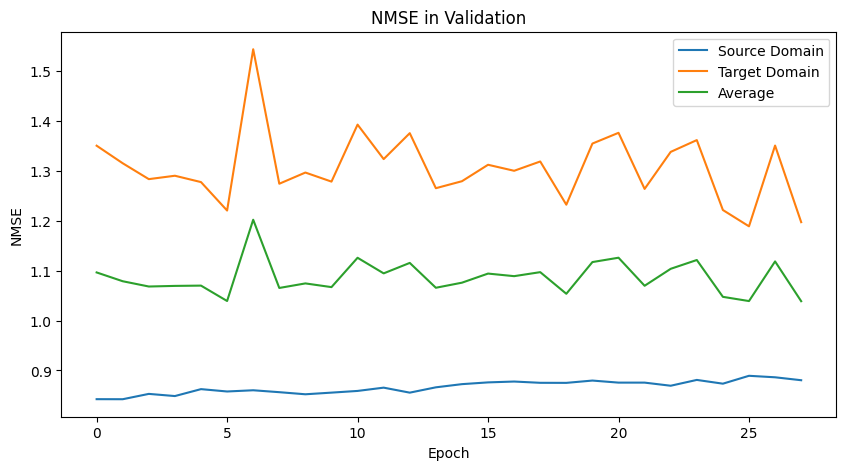

<Figure size 640x480 with 0 Axes>

In [11]:
plotfig.figLoss(line_list=[(nmse_val_source[42:], 'Source Domain'), (nmse_val_target[42:], 'Target Domain'), (nmse_val[42:], 'Average')], xlabel='Epoch', ylabel='NMSE',
                        title='NMSE in Validation', index_save=1, fig_show=True, fig_name='NMSE_val')
            

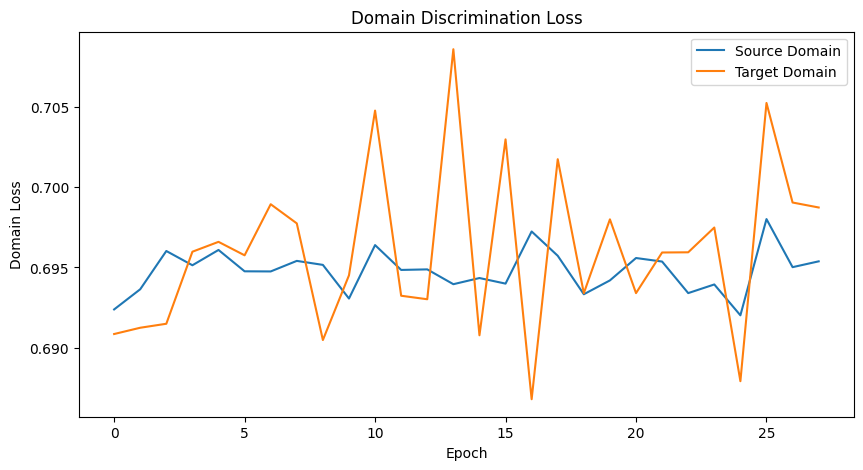

<Figure size 640x480 with 0 Axes>

In [12]:
plotfig.figLoss(line_list=[(train_domain_loss[42:], 'Source Domain'), (val_domain_loss[42:], 'Target Domain')], xlabel='Epoch', ylabel='Domain Loss',
                        title='Domain Discrimination Loss', index_save=1, fig_show=True)
            